In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
import tensorflow as tf
import pandas as pd
import numpy as np
import _pickle as cPickle

print("This notebook uses TensorFlow version {}".format(tf.__version__))

This notebook uses TensorFlow version 1.4.1


In [2]:
vocab = cPickle.load(open('dataset/vocab.pkl', 'rb'))
print('total {} vocabularies'.format(len(vocab)))

total 26900 vocabularies


In [3]:
def count_vocab_occurance(vocab, df):
    voc_cnt = {v: 0 for v in vocab}
    for img_id, row in df.iterrows():
        for w in row['caption'].split(' '):
            voc_cnt[w] += 1
    return voc_cnt


df_train = pd.read_csv(os.path.join('dataset', 'train.csv'))

print('count vocabulary occurances...')
voc_cnt = count_vocab_occurance(vocab, df_train)

# remove words appear < 50 times
thrhd = 50
x = np.array(list(voc_cnt.values()))
print('{} words appear >= 50 times'.format(np.sum(x[(-x).argsort()] >= thrhd)))

count vocabulary occurances...
3153 words appear >= 50 times


In [4]:
def build_voc_mapping(voc_cnt, thrhd):
    """
    enc_map: voc --encode--> id
    dec_map: id --decode--> voc
    """

    def add(enc_map, dec_map, voc):
        enc_map[voc] = len(dec_map)
        dec_map[len(dec_map)] = voc
        return enc_map, dec_map

    # add <ST>, <ED>, <RARE>
    enc_map, dec_map = {}, {}
    for voc in ['<ST>', '<ED>', '<RARE>']:
        enc_map, dec_map = add(enc_map, dec_map, voc)
    for voc, cnt in voc_cnt.items():
        if cnt < thrhd:  # rare words => <RARE>
            enc_map[voc] = enc_map['<RARE>']
        else:
            enc_map, dec_map = add(enc_map, dec_map, voc)
    return enc_map, dec_map


enc_map, dec_map = build_voc_mapping(voc_cnt, thrhd)
# save enc/decoding map to disk
cPickle.dump(enc_map, open('dataset/enc_map.pkl', 'wb'))
cPickle.dump(dec_map, open('dataset/dec_map.pkl', 'wb'))
def caption_to_ids(enc_map, df):
    img_ids, caps = [], []
    for idx, row in df.iterrows():
        icap = [enc_map[x] for x in row['caption'].split(' ')]
        icap.insert(0, enc_map['<ST>'])
        icap.append(enc_map['<ED>'])
        img_ids.append(row['img_id'])
        caps.append(icap)
    return pd.DataFrame({
              'img_id': img_ids,
              'caption': caps
            }).set_index(['img_id'])


enc_map = cPickle.load(open('dataset/enc_map.pkl', 'rb'))
print('[transform captions into sequences of IDs]...')
df_proc = caption_to_ids(enc_map, df_train)
df_proc.to_csv('dataset/train_enc_cap.csv')

[transform captions into sequences of IDs]...


In [5]:
df_cap = pd.read_csv(
    'dataset/train_enc_cap.csv')  # a dataframe - 'img_id', 'cpation'
enc_map = cPickle.load(
    open('dataset/enc_map.pkl', 'rb'))  # token => id
dec_map = cPickle.load(
    open('dataset/dec_map.pkl', 'rb'))  # id => token
vocab_size = len(dec_map)


def decode(dec_map, ids):
    """decode IDs back to origin caption string"""
    return ' '.join([dec_map[x] for x in ids])


print('decoding the encoded captions back...\n')
for idx, row in df_cap.iloc[:8].iterrows():
    print('{}: {}'.format(idx, decode(dec_map, eval(row['caption']))))

decoding the encoded captions back...

0: <ST> a group of three women sitting at a table sharing a cup of tea <ED>
1: <ST> three women wearing hats at a table together <ED>
2: <ST> three women with hats at a table having a tea party <ED>
3: <ST> several woman dressed up with fancy hats at a tea party <ED>
4: <ST> three women wearing large hats at a fancy tea event <ED>
5: <ST> a twin door refrigerator in a kitchen next to cabinets <ED>
6: <ST> a black refrigerator freezer sitting inside of a kitchen <ED>
7: <ST> black refrigerator in messy kitchen of residential home <ED>


In [6]:
img_train = cPickle.load(open('dataset/train_img256.pkl', 'rb'))
# transform img_dict to dataframe
img_train_df = pd.DataFrame(list(img_train.items()), columns=['img_id', 'img'])
print('Images for training: {}'.format(img_train_df.shape[0]))

Images for training: 102739


In [7]:
def create_tfrecords(df_cap, img_df, filename, num_files=5):
    ''' create tfrecords for dataset '''

    def _float_feature(value):
        return tf.train.Feature(
            float_list=tf.train.FloatList(value=value))

    def _int64_feature(value):
        return tf.train.Feature(
            int64_list=tf.train.Int64List(value=value))

    num_records_per_file = img_df.shape[0] // num_files

    total_count = 0

    print("create training dataset....")
    for i in range(num_files):
        # tfrecord writer: write record into files
        count = 0
        writer = tf.python_io.TFRecordWriter(
            filename + '-' + str(i + 1) +'.tfrecords')
        
        # start point (inclusive)
        st = i * num_records_per_file  
        # end point (exclusive)
        ed = (i + 1) * num_records_per_file if i != num_files - 1 else img_df.shape[0]  

        for idx, row in img_df.iloc[st:ed].iterrows():
        
            # img representation in 256-d array format
            img_representation = row['img']  

            # each image has some captions describing it.
            for _, inner_row in df_cap[df_cap['img_id'] == row['img_id']].iterrows():
                # caption in different sequence length list format
                caption = eval(inner_row['caption'])  

                # construct 'example' object containing 'img', 'caption'
                example = tf.train.Example(features=tf.train.Features(
                    feature={
                        'img': _float_feature(img_representation),
                        'caption': _int64_feature(caption)
                    }))

                count += 1
                writer.write(example.SerializeToString())
        print("create {}-{}.tfrecords -- contains {} records".format(
                                    filename, str(i + 1), count))
        total_count += count
        writer.close()
    print("Total records: {}".format(total_count))

In [8]:
# uncomment next line to create tfrecords file
#create_tfrecords(df_cap, img_train_df, 'dataset/train', 10)

In [9]:
import glob
training_filenames = glob.glob('dataset/train-*')

# get the number of records in training files
def get_num_records(files):
    count = 0
    for fn in files:
        for record in tf.python_io.tf_record_iterator(fn):
            count += 1
    return count

num_train_records = get_num_records(training_filenames)
print('Number of training records in all training file: {}'.format(
    num_train_records))

Number of training records in all training file: 513969


In [10]:
def training_parser(record):
    ''' parse record from .tfrecords file and create training record

    :args 
      record - each record extracted from .tfrecords
    :return
      a dictionary contains {
          'img': image array extracted from vgg16 (256-dim),
          'input_seq': a list of word id
                    which describes input caption sequence (Tensor),
          'output_seq': a list of word id
                    which describes output caption sequence (Tensor),
          'mask': a list of one which describe
                    the length of input caption sequence (Tensor)
      }
    '''

    keys_to_features = {
      "img": tf.FixedLenFeature([256], dtype=tf.float32),
      "caption": tf.VarLenFeature(dtype=tf.int64)
    }

    # features contains - 'img', 'caption'
    features = tf.parse_single_example(record, features=keys_to_features)

    img = features['img']
    caption = features['caption'].values
    caption = tf.cast(caption, tf.int32)

    # create input and output sequence for each training example
    # e.g. caption :   [0 2 5 7 9 1]
    #      input_seq:  [0 2 5 7 9]
    #      output_seq: [2 5 7 9 1]
    #      mask:       [1 1 1 1 1]
    caption_len = tf.shape(caption)[0]
    input_len = tf.expand_dims(tf.subtract(caption_len, 1), 0)

    input_seq = tf.slice(caption, [0], input_len)
    output_seq = tf.slice(caption, [1], input_len)
    mask = tf.ones(input_len, dtype=tf.int32)

    records = {
      'img': img,
      'input_seq': input_seq,
      'output_seq': output_seq,
      'mask': mask,
      'input_len' : input_len
    }

    return records

In [11]:
def tfrecord_iterator(filenames, batch_size, record_parser):
    ''' create iterator to eat tfrecord dataset 

    :args
        filenames     - a list of filenames (string)
        batch_size    - batch size (positive int)
        record_parser - a parser that read tfrecord
                        and create example record (function)

    :return 
        iterator      - an Iterator providing a way
                        to extract elements from the created dataset.
        output_types  - the output types of the created dataset.
        output_shapes - the output shapes of the created dataset.
    '''
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(record_parser, num_parallel_calls=16)

    # padded into equal length in each batch
    dataset = dataset.padded_batch(
      batch_size=batch_size,
      padded_shapes={
          'img': [None],
          'input_seq': [None],
          'output_seq': [None],
          'mask': [None],
          'input_len': [None]
      },
      padding_values={
          'img': 1.0,       # needless, for completeness
          'input_seq': 1,   # padding input sequence in this batch
          'output_seq': 1,  # padding output sequence in this batch
          'mask': 0,      # padding 0 means no words in this position
          'input_len': 0
      })  

    dataset = dataset.repeat()             # repeat dataset infinitely
    dataset = dataset.shuffle(3*batch_size)  # shuffle the dataset

    iterator = dataset.make_initializable_iterator()
    output_types = dataset.output_types
    output_shapes = dataset.output_shapes

    return iterator, output_types, output_shapes

In [12]:
def get_seq_embeddings(input_seq, vocab_size, word_embedding_size):
    with tf.variable_scope('seq_embedding'), tf.device("/cpu:0"):
        embedding_matrix = tf.get_variable(
            name='embedding_matrix',
            shape=[vocab_size, word_embedding_size],
            initializer=tf.random_uniform_initializer(minval=-1, maxval=1))
        # [batch_size, padded_length, embedding_size]
        seq_embeddings = tf.nn.embedding_lookup(embedding_matrix, input_seq)
    return seq_embeddings

In [33]:
import time
import sys

class ImageCaptionModel(object):
    ''' simple image caption model '''

    def __init__(self, hparams):
        self.hps = hparams

    def _build_inputs(self):
        """ construct the inputs for model """
        self.filenames = tf.placeholder(tf.string,shape=[None], name='filenames')
        self.test_image = tf.placeholder(tf.float32, shape=[1, self.hps.image_embedding_size], name='test_image')
        
        self.training_iterator, types, shapes = tfrecord_iterator(
          self.filenames, self.hps.batch_size, training_parser)

        self.handle = tf.placeholder(tf.string, shape=[], name='handle')
        self.iterator = tf.data.Iterator.from_string_handle(self.handle,
                                                       types, shapes)
        self.records = self.iterator.get_next()

        image_embed = self.records['img']
        image_embed.set_shape([None, self.hps.image_embedding_size])
        input_seq = self.records['input_seq']
        target_seq = self.records['output_seq']
        input_mask = self.records['mask']
        input_len = tf.reshape(self.records['input_len'], [-1])
        
        self.image_embed = image_embed # (batch_size, img_dim)
        self.input_seq = input_seq # (batch_size, seqlen)
        self.target_seq = target_seq # (batch_size, seqlen)
        self.input_mask = input_mask # (batch_size, seqlen)
        self.input_len = input_len #(batch_size, 1)
            
        # convert sequence of index to sequence of embedding
        with tf.variable_scope('seq_embedding'), tf.device('/cpu:0'):
            self.embedding_matrix = tf.get_variable(
                    name='embedding_matrix',
                    shape=[self.hps.vocab_size,
                           self.hps.word_embedding_size],
                    initializer=tf.random_uniform_initializer(
                        minval=-1, maxval=1))
            # [batch_size, seqlen, embedding_size]
            self.seq_embeddings = tf.nn.embedding_lookup(
                self.embedding_matrix, self.input_seq)
        
    def _build_model(self, mode="train"):
        """ Build your image caption model """
        
        with tf.variable_scope('seq2seq_rnn'):
            
            self.out_cell = tf.contrib.rnn.LSTMCell(256)
            
            helper = tf.contrib.seq2seq.TrainingHelper(
                inputs=self.seq_embeddings,
                sequence_length=self.input_len)
                
#             if mode == "test":
#                 helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(
#                     embedding = self.embedding_matrix,
#                     start_tokens = tf.tile(tf.constant([0], dtype=tf.int32), [self.hps.batch_size]),
#                     end_token = 1)
                
            projection_layer = tf.layers.Dense(self.hps.vocab_size, use_bias=False)
            
            initial_state = tf.nn.rnn_cell.LSTMStateTuple(
            c=self.image_embed,
            h=self.image_embed)
            
            decoder = tf.contrib.seq2seq.BasicDecoder(
                cell=self.out_cell,
                helper=helper,
                initial_state=initial_state,
                output_layer=projection_layer)
            
            outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(
               decoder=decoder,
               output_time_major=False,
               impute_finished=True#, maximum_iterations=20
                )
            
        with tf.variable_scope('loss'):
            self.global_step = tf.Variable(0, trainable=False)
            logits = outputs.rnn_output
            self.loss = tf.contrib.seq2seq.sequence_loss(logits = logits,
                                                         targets = self.target_seq,
                                                         weights = tf.cast(self.input_mask, dtype=tf.float32))


            # create an optimizer
            optimizer = tf.train.AdamOptimizer(learning_rate=self.hps.lr)
            # compute the gradients of a list of variables
            grads_and_vars = optimizer.compute_gradients(self.loss,tf.trainable_variables())
            # grads_and_vars is a list of tuple (gradient, variable)
            # do whatever you need to the 'gradients' part
            clipped_grads_and_vars = [(tf.clip_by_norm(gv[0], 1.0), gv[1]) for gv in grads_and_vars]
            # apply gradient and variables to optimizer
            self.train_op = optimizer.apply_gradients( clipped_grads_and_vars, global_step=self.global_step)
            
        with tf.variable_scope('predict'):
            predict_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(
                embedding = self.embedding_matrix,
                start_tokens = tf.tile(tf.constant([0], dtype=tf.int32), [self.hps.batch_size]),
                end_token = 1)
            
            #self.test_image = tf.reshape(self.test_image, (-1, self.hps.image_embedding_size))
            test_initial_state = tf.nn.rnn_cell.LSTMStateTuple(
                    c=tf.contrib.seq2seq.tile_batch(self.test_image, multiplier=self.hps.batch_size),
                    h=tf.contrib.seq2seq.tile_batch(self.test_image, multiplier=self.hps.batch_size))
            
            predict_decoder = tf.contrib.seq2seq.BasicDecoder(
                cell=self.out_cell,
                helper=predict_helper,
                initial_state=test_initial_state,
                output_layer=projection_layer)

            output, _, _ = tf.contrib.seq2seq.dynamic_decode(predict_decoder)
            self.predicting_logits = output.sample_id
        
    def build(self):
        """ call this function to build the inputs and model """
        self._build_inputs()
        self._build_model()
        
    def train(self, sess, training_filenames, num_train_records, model_version=None):
        """ write a training function for your model """
        
        saver = tf.train.Saver()
        init =  tf.global_variables_initializer()
        sess = tf.Session(config = config)
        sess.run(init)
        if model_version != None:
            saver.restore(sess, self.hps.ckpt_dir+'model.ckpt-'+model_version)
        
        
        training_handle = sess.run(self.training_iterator.string_handle())
        sess.run(self.training_iterator.initializer, feed_dict={self.filenames: training_filenames,
                                                        self.handle: training_handle})

        
        
        steps = num_train_records//self.hps.batch_size
            
        for step in range(self.hps.training_epochs*steps):
            start_time = time.time()

            loss, _ = sess.run([self.loss, self.train_op], feed_dict={self.handle: training_handle})

            duration = time.time() - start_time

            assert not np.isnan(loss), 'Model diverged with loss = NaN'

            if step % self.hps.print_frequency== 0:
                num_examples_per_step = self.hps.batch_size
                examples_per_sec = num_examples_per_step / duration
                sec_per_batch = float(duration)

                format_str = ('step %d, loss = %.5f (%.1f examples/sec; %.3f '
                              'sec/batch)')
                print (format_str % (step, loss,
                                     examples_per_sec, sec_per_batch), file=open(self.hps.log_file, "a"))
                print (format_str % (step, loss,
                                     examples_per_sec, sec_per_batch))

                sys.stdout.flush()
                
            if step % self.hps.save_frequency == 0:
                saver.save(sess, self.hps.ckpt_dir + '/model.ckpt', global_step=step)
        sess.close()
    
    def predict(self, sess, img_vec, dec_map, model_version=None, init=True):
        """ generate the caption given an image """
           
        if init:
            init =  tf.global_variables_initializer()
            sess.run(init)
        if model_version != None:
            saver = tf.train.Saver()
            saver.restore(sess, self.hps.ckpt_dir+'model.ckpt-'+model_version)
            
        img_vec = np.reshape(img_vec, (1, -1))

        caption_ids = sess.run(self.predicting_logits, feed_dict={self.test_image: img_vec})
        
        caption = []
        for i in range(caption_ids.shape[1]):
            if(caption_ids[0, i] < 0):
                break
            caption.append(dec_map[caption_ids[0, i]])
            
        return caption_ids, caption

In [14]:
def get_hparams():
    hparams = tf.contrib.training.HParams(
      vocab_size=vocab_size,
      batch_size=128,
      rnn_units=100,
      image_embedding_size=256,
      word_embedding_size=256,
      drop_keep_prob=0.7,
      lr=2e-4,
      training_epochs=2,
      max_caption_len=15,
      ckpt_dir='model_ckpt/',
        print_frequency=100,
        save_frequency=4000,
        log_file='ver1.txt')
    return hparams

In [15]:
# get hperparameters
hparams = get_hparams()
# create model
tf.reset_default_graph()
model = ImageCaptionModel(hparams)
model.build()
# start training
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction=0.8
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
model.train(sess, training_filenames, num_train_records, "40000")

INFO:tensorflow:Restoring parameters from model_ckpt/model.ckpt-40000
step 0, loss = 2.02967 (98.7 examples/sec; 1.296 sec/batch)
step 100, loss = 2.12561 (3348.1 examples/sec; 0.038 sec/batch)
step 200, loss = 2.08273 (3768.9 examples/sec; 0.034 sec/batch)
step 300, loss = 2.25347 (2747.4 examples/sec; 0.047 sec/batch)
step 400, loss = 1.95879 (3122.9 examples/sec; 0.041 sec/batch)
step 500, loss = 2.24160 (2806.8 examples/sec; 0.046 sec/batch)
step 600, loss = 2.32181 (3867.9 examples/sec; 0.033 sec/batch)
step 700, loss = 2.14403 (3770.8 examples/sec; 0.034 sec/batch)
step 800, loss = 2.33176 (3772.7 examples/sec; 0.034 sec/batch)
step 900, loss = 2.10781 (3156.0 examples/sec; 0.041 sec/batch)
step 1000, loss = 1.99909 (2335.9 examples/sec; 0.055 sec/batch)
step 1100, loss = 2.08612 (4112.6 examples/sec; 0.031 sec/batch)
step 1200, loss = 2.09239 (3377.0 examples/sec; 0.038 sec/batch)
step 1300, loss = 2.11553 (2261.5 examples/sec; 0.057 sec/batch)
step 1400, loss = 2.14501 (3682.2 

In [34]:
# get hperparameters
hparams = get_hparams()
# create model
tf.reset_default_graph()
model = ImageCaptionModel(hparams)
model.build()
# start training
testimg = img_train_df.iloc[10]['img']

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction=0.8
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
ids, caption = model.predict(sess, testimg, dec_map, "8000")
print(ids[0])
print(caption)

INFO:tensorflow:Restoring parameters from model_ckpt/model.ckpt-8000
[2045  166 1637  453  782 1405 2284 1612 2045 1195    1]
['a', 'train', 'is', 'traveling', 'down', 'the', 'tracks', 'near', 'a', 'platform', '<ED>']


In [16]:
import _pickle as cPickle
import numpy as np
import tensorflow as tf

class PretrainedCNN:
    def __init__(self, weight_path, mdl_name='vgg16'):
        self.mdl_name = mdl_name
        self.model = self.build_model(weight_path)
    def build_model(self, weight_path):
        if self.mdl_name == 'vgg16':
            self.params = []
            ws = cPickle.load(open(weight_path, 'rb'))
            self.img = tf.placeholder(tf.float32, [None, 224, 224, 3])
            self.label = tf.placeholder(tf.float32, [None, 1000])
            x = self.img
            x = self.conv('conv1_1', x, ws[:2])
            x = self.conv('conv1_2', x, ws[2:4])
            x = self.pool('pool1', x)
            x = self.conv('conv2_1', x, ws[4:6])
            x = self.conv('conv2_2', x, ws[6:8])
            x = self.pool('pool2', x)
            x = self.conv('conv3_1', x, ws[8:10])
            x = self.conv('conv3_2', x, ws[10:12])
            x = self.conv('conv3_3', x, ws[12:14])
            x = self.pool('pool3', x)
            x = self.conv('conv4_1', x, ws[14:16])
            x = self.conv('conv4_2', x, ws[16:18])
            x = self.conv('conv4_3', x, ws[18:20])
            x = self.pool('pool4', x)
            x = self.conv('conv5_1', x, ws[20:22])
            x = self.conv('conv5_2', x, ws[22:24])
            x = self.conv('conv5_3', x, ws[24:26])
            x = self.pool('pool5', x)
            s = int(np.prod(x.get_shape()[1:]))
            self.ext = tf.reshape(x, [-1, s])
            x = self.fc('fc1', self.ext, ws[26:28])
            x = self.fc('fc2', x, ws[28:30])
            self.out = self.fc('pred', x, ws[30:32], act=False)
    def conv(self, name, x, ws):
        with tf.name_scope(name) as scope:
            W = tf.Variable(ws[0], trainable=True, name='weights')
            b = tf.Variable(ws[1], trainable=True, name='biases')
            conv = tf.nn.conv2d(x, W, [1,1,1,1], padding='SAME')
            out = tf.nn.relu(tf.nn.bias_add(conv, b), name=scope)
            self.params += [W, b]
            return out
    def pool(self, name, x):
        return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME', name=name)
    def fc(self, name, x, ws, act=True):
        with tf.name_scope(name) as scope:
            W = tf.Variable(ws[0], trainable=True, name='weights')
            b = tf.Variable(ws[1], trainable=True, name='biases')
            out = tf.nn.bias_add(tf.matmul(x, W), b)
            out = tf.nn.relu(out) if act else out
            self.params += [W, b]
            return out
    def get_output(self, sess, X):
        layer_outputs = sess.run([self.ext], feed_dict={self.img:X})
        return layer_outputs

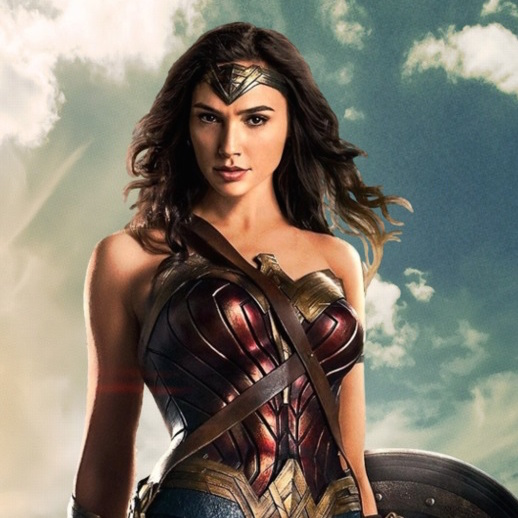

/home/assistant/anaconda3/envs/ros/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


INFO:tensorflow:Restoring parameters from model_ckpt/model.ckpt-8000
[2045  466 1637 1488 2045  929  891 2045 2185    1]
['a', 'man', 'is', 'riding', 'a', 'skateboard', 'on', 'a', 'ramp', '<ED>']


In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image, display
import imageio
import skimage.transform
import numpy as np
import scipy

def demo(img_path, cnn_mdl, U, dec_map, hparams, max_len=15):
    """
    displays the caption generated for the image
    -------------------------------
    img_path: image to be captioned
    cnn_mdl: path of the image feature extractor
    U: transform matrix to perform PCA
    dec_map: mapping of vocabulary ID => token string
    hparams: hyperparams for model
    """

    def process_image(img, crop=True, submean=True):
        """
        implements the image preprocess required by VGG-16
        -------------------------------
        resize image to 224 x 224
        crop: do center-crop [skipped by default]
        submean: substracts mean image of ImageNet [skipped by default]
        """
        MEAN = np.array([103.939, 116.779, 123.68]).astype(np.float32) # BGR
        # center crop
        short_edge = min(img.shape[:2])
        yy = int((img.shape[0] - short_edge) / 2)
        xx = int((img.shape[1] - short_edge) / 2)
        crop_img = img[yy: yy + short_edge, xx: xx + short_edge]
        img = skimage.transform.resize(crop_img, [224, 224, 3], mode="constant")
        img = img.reshape((224,224,1)) if len(img.shape) < 3 else img
        
        if img.shape[2] < 3:
            print('dimension insufficient')
            img = img.reshape((224*224,
                               img.shape[2])).T.reshape((img.shape[2],
                                                                 224*224))
            for i in range(img.shape[0], 3):
                img = np.vstack([img, img[0,:]])
            img = img.reshape((3,224*224)).T.reshape((224,224,3))
        img = img.astype(np.float32)
        img = img[:,:,::-1]
        # RGB => BGR
        for i in range(3):
            img[:,:,i] -= MEAN[i]
        return img.reshape((224,224,3))

    display(Image(img_path))
    img = imageio.imread(img_path)
    
    # load pretrained cnn model
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())
        img_feature = np.dot(
            cnn_mdl.get_output(sess, [process_image(img)])[0].reshape((-1)), U)
        
    # reset graph for image caption model
    tf.reset_default_graph()  
    model = ImageCaptionModel(hparams)
    model.build()
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction=0.8
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    ids, caption = model.predict(sess, img_feature, dec_map, "8000")
    print(ids[0])
    print(caption)


tf.reset_default_graph()  # reset graph for cnn model
U = cPickle.load(open('dataset/U.pkl', 'rb'))  # PCA transforming matrix
vgg = PretrainedCNN('dataset/vgg16_mat.pkl')
demo('dataset/test1.jpg', vgg, U, dec_map, hparams)

In [37]:
model_version="8000"
def generate_captions(model, dec_map, img_test, max_len=15):
    img_ids, caps = [], []
  
    with tf.Session() as sess:
        # restore variables from disk. 
        saver = tf.train.Saver()
        saver.restore(sess, get_hparams().ckpt_dir+'model.ckpt-'+model_version)
        print("Start testing...")
        for img_id, img in img_test.items():
            img_ids.append(img_id)
            _, caption = model.predict(sess, img, dec_map, None, False)
            caps.append(caption)
            print("ID : "+img_id + " ,Caption : "+" ".join(caption), file=open(get_hparams().log_file, "a"))
    
    return pd.DataFrame({
              'img_id': img_ids,
              'caption': caps
            }).set_index(['img_id'])

In [40]:
# load test image  size=20548
img_test = cPickle.load(open('dataset/test_img256.pkl', 'rb'))

# create model
# tf.reset_default_graph()
# model = ImageCaptionModel(hparams)
# model.build()

# generate caption to csv file
df_predict = generate_captions(model, dec_map, img_test)
df_predict.to_csv('predict/demo.csv')

In [3]:
import os

os.system('cd CIDErD && ./gen_score -i ../predict/demo.csv -r ../predict/score.csv')

0

In [ ]:
os.system('remote add origin https://github.com/jackraken/Tensorflow-ImageCaption.git')